In [1]:
# import libraries and dependencies
import numpy as np
import pandas as pd
from pathlib import Path
import random
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from arch import arch_model
%matplotlib inline

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [3]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


In [4]:
yen_futures.describe()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
count,7515.000000,7515.000000,7515.000000,7515.000000,1415.000000,7515.000000,7515.000000,7515.000000
mean,9246.579973,9277.437591,9217.774451,9246.708849,35.412014,9246.799268,54787.383766,120491.742382
std,1368.518888,1370.779563,1366.107886,1368.302814,33.796052,1368.261725,64548.071131,62190.538169
min,6265.000000,6277.000000,6254.000000,6273.000000,0.500000,6273.000000,0.000000,0.000000
25%,8353.000000,8380.000000,8331.500000,8354.000000,12.000000,8353.250000,10463.500000,70223.000000
50%,9064.000000,9094.000000,9034.000000,9061.000000,27.000000,9061.500000,22418.000000,105688.000000
75%,9774.000000,9810.000000,9742.000000,9777.000000,49.500000,9776.000000,93340.500000,163333.000000
max,13217.000000,13264.000000,13167.000000,13210.000000,329.500000,13210.000000,857206.000000,347980.000000


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

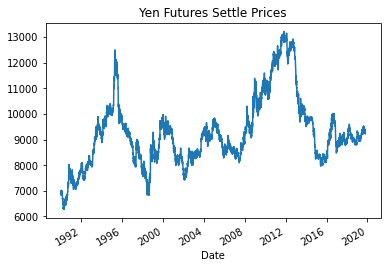

In [5]:
# Plot just the "Settle" column from the dataframe:
plot_yen_futures = yen_futures['Settle'].plot(x='Date',title='Yen Futures Settle Prices')

### Question 1: Do you see any patterns, long-term and/or short?

* *There is a general upwards trend in the settle price in the long-term. In the short-term, the price seems to be volatile.*

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

<AxesSubplot:title={'center':'Yen Futures Settle Prices Trend'}, xlabel='Date'>

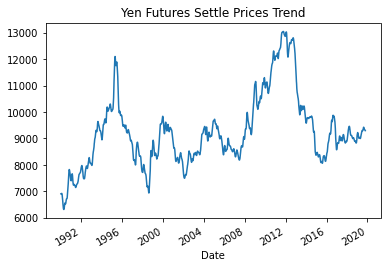

In [6]:
# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
settle_noise, settle_trend = sm.tsa.filters.hpfilter(yen_futures['Settle'])
settle_trend.plot(title='Yen Futures Settle Prices Trend')

<AxesSubplot:title={'center':'Yen Futures Settle Prices Noise'}, xlabel='Date'>

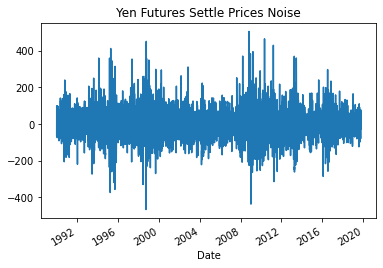

In [7]:
settle_noise.plot(title='Yen Futures Settle Prices Noise')

In [8]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
yen_settle_df = pd.DataFrame(yen_futures['Settle']) # create new df
yen_settle_df['Noise']=settle_noise # add column with 'noise' data
yen_settle_df['Trend']=settle_trend # add column with 'trend' data
yen_settle_df.head()

,Settle,Noise,Trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062


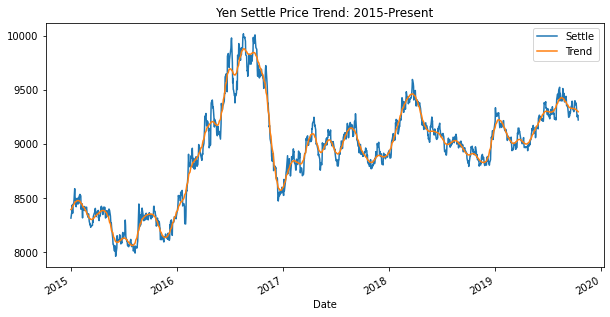

In [9]:
# Plot the Settle Price vs. the Trend for 2015 to the present
yen_settle_2015 = yen_settle_df['Settle'].loc['2015':,]
yen_trend_2015 = yen_settle_df['Trend'].loc['2015':,]
settle_plot = yen_settle_2015.plot(legend=['Settle'],figsize=(10,5),title='Yen Settle Price Trend: 2015-Present')
trend_plot = yen_trend_2015.plot(legend=['Trend'])

<AxesSubplot:title={'center':'Yen Settle Price Noise: 2015-Present'}, xlabel='Date'>

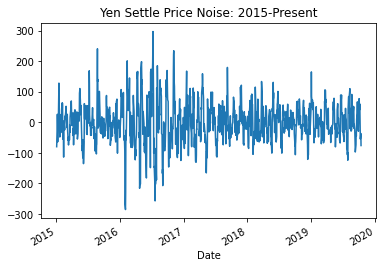

In [10]:
# Plot the Settle Noise
yen_noise_2015 = yen_settle_df['Noise'].loc['2015':,]
yen_noise_2015.plot(title='Yen Settle Price Noise: 2015-Present')

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [11]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
yen_futures['Return'] = returns
yen_futures.tail()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return
Date,,,,,,,,,
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0,-0.410601
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0,-0.369458
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0,-0.564304
2019-10-14,9259.0,9292.0,9250.5,9261.0,14.0,9265.0,69457.0,153902.0,0.151335
2019-10-15,9264.5,9280.0,9216.5,9220.0,43.5,9221.5,108342.0,151564.0,-0.469509


In [12]:
# Estimate and ARMA model using statsmodels (use order=(2, 1))
arma_model = ARMA(returns.values,order=(2,1))
# Fit the model and assign it to a variable called arma_results
arma_results = arma_model.fit()

In [13]:
# Output model summary results:
arma_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Wed, 24 Feb 2021   AIC                          15798.142
Time:                        18:09:54   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.008      0.804      0.422      -0.009       0.022
ar.L1.y       -0.3064      1.277     -0.240      0.810      -2.809       2.197
ar.L2.y       -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.y        0.2948      1.277      0.231      0.817      -2.208       2.798
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3331           +0.0000j            3.3331            0.5000
AR.2         -157.1311           +0.0000j          157.1311            0.5000
MA.1           -3.3920           +0.0000j            3.3920            0.5000
-----------------------------------------------------------------------------
"""

### Question 2: Based on the p-values, is the model a good fit (p < 0.05)?

* *The above ARMA model is not a good fit, since the models results have a p-value (0.422) that is greater than the significance level of 0.05. Therefore, the coefficient of the autoregressive moving average is not statistcally significant, and should NOT be kept in the model.*

<AxesSubplot:title={'center':'Yen Settle 5 Day Returns Forecast'}>

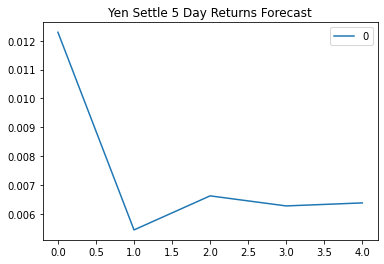

In [14]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(arma_results.forecast(steps=5)[0]).plot(title='Yen Settle 5 Day Returns Forecast')


---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [15]:
# Estimate and ARIMA Model:
arima_model = ARIMA(yen_futures['Settle'].values,order=(5,1,1))

# Fit the model
arima_results = arima_model.fit()

In [16]:
# Output model summary results:
arima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Wed, 24 Feb 2021   AIC                          83905.238
Time:                        18:09:56   BIC                          83960.635
Sample:                             1   HQIC                         83924.259
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3161      0.700      0.452      0.652      -1.056       1.688
ar.L1.D.y      0.2824      0.699      0.404      0.686      -1.088       1.652
ar.L2.D.y      0.0007      0.016      0.043      0.966      -0.030       0.032
ar.L3.D.y     -0.0126      0.012     -1.032      0.302      -0.037       0.011
ar.L4.D.y     -0.0137      0.015     -0.889      0.374      -0.044       0.016
ar.L5.D.y     -0.0012      0.018     -0.064      0.949      -0.036       0.034
ma.L1.D.y     -0.2974      0.699     -0.426      0.670      -1.667       1.072
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8920           -1.3784j            2.3409           -0.1002
AR.2            1.8920           +1.3784j            2.3409            0.1002
AR.3           -2.2712           -3.0199j            3.7786           -0.3526
AR.4           -2.2712           +3.0199j            3.7786            0.3526
AR.5          -11.1067           -0.0000j           11.1067           -0.5000
MA.1            3.3623           +0.0000j            3.3623            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Days Futures Price Forecast'}>

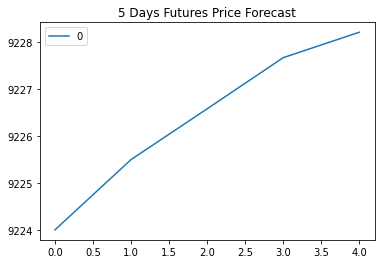

In [17]:
# Plot the 5 Day Price Forecast
pd.DataFrame(arima_results.forecast(steps=5)[0]).plot(title='5 Days Futures Price Forecast')

### Question 3: What does the model forecast will happen to the Japanese Yen in the near term?

* *The ARIMA results model forecasts that the Japanese Yen will increase in the near term. However, the autoregressive term has a p-value (0.652) that is greater than the significance level of 0.05. Therefore, the autoregressive term from this model is NOT statistically significant, and should not be relied on to forecast Yen futures accurately.*

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [18]:
# Estimate a GARCH model:
garch_model = arch_model(returns, mean='Zero',vol='GARCH',p=1,q=1)

# Fit the model
garch_results = garch_model.fit(disp='off')

In [19]:
# Summarize the model results
garch_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14929.9
Method:            Maximum Likelihood   BIC:                           14950.6
                                        No. Observations:                 7514
Date:                Wed, Feb 24 2021   Df Residuals:                     7514
Time:                        18:09:56   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      4.2895e-03  1.798e-03      2.385  1.707e-02 [7.646e-04,7.814e-03]
alpha[1]       0.0381  8.773e-03      4.341  1.419e-05 [2.089e-02,5.528e-02]
beta[1]        0.9536  1.114e-02     85.623      0.000     [  0.932,  0.975]
============================================================================

Covariance estimator: robust
"""

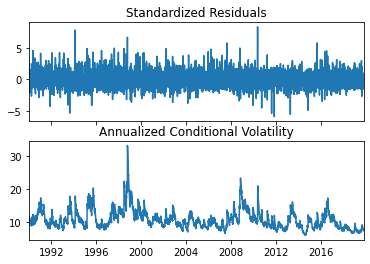

In [20]:
# Plot the model estimate of annualized volatility

fig = garch_results.plot(annualize='D')

### Question 4: Based on the p-values, is the model a good fit (p < 0.05)?

* *The GARCH model above results in a p-value (0.00171) that is lower than the significance level of 0.05, which means this model is highly statistically significant.*

In [21]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [22]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecasts = garch_results.forecast(start=last_day,horizon=forecast_horizon)

In [23]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.434026,7.475721,7.516842,7.5574,7.597407


In [24]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15
h.1,7.434026
h.2,7.475721
h.3,7.516842
h.4,7.557400
h.5,7.597407


<AxesSubplot:>

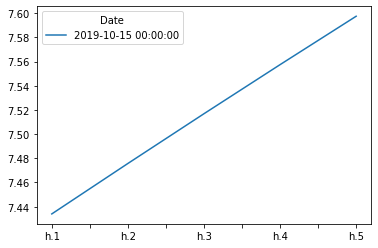

In [25]:
# Plot the final forecast
final.plot()

---

# Conclusions:

### Based on your time series analysis, would you buy the yen now?

* *The model demonstrates a consistently high confidence interval, so we can conclude the GARCH model is a good fit.* 

* *The beta coefficient (0.95) indicates the slight increase in volatility is expected in the long-term, while the alpha coefficient (0.04) suggests a historically stable return on asset; the alpha and beta combined (0.99) suggests the stable volatility of this asset will persist in the long-term.*

### Is the risk of the yen expected to increase or decrease?

* *Based on the upward trend in the forecast plot, the exchange rate risk is expected to increase slightly over the next 5 days.* 

### Based on the model evaluation, would you feel confident in using these models for trading?

#### *Forecasting Returns using an ARMA Model:*
* *The ARMA model is not a good fit, since the p-value (0.422) is greater than the significane level of 0.05.*

* *Therefore, the coefficient of the autoregressive moving average is NOT statistically significant, and should NOT be kept in the model.*

#### *Forecasting Settle Price using an ARIMA Model:*
* *The ARIMA model forecasts that the Japanese Yen will increase in the near term. However, the autoregressive term has a p-value (0.652) that is greater than the significance level of 0.05.*

* *Therefore, the autoregressive term from this model is NOT statistically significant, and should NOT be relied on to forecast Yen futures accurately.*

#### *Volatility Forecasting with GARCH Model:*
* *The GARCH model results in a p-value (0.00171) that is lower than the significance level of 0.05.  Therefore, this model is statistically significant. The model demonstrates a consistently high confidence interval, so we can conclude the GARCH model is a good fit.*

* *Further analysis using the exponentially weighted moving average (EWMA) to determine if investment in this asset is recommended, since the calculations may be diluted by the distant (less relevant) data.*



